# Supervised Learning

Charles Green

## Libraries, Settings, & Functions

In [0]:
# Import libraries
import glob, os 
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set()

In [0]:
import scipy.stats as stats
from scipy.stats.mstats import winsorize

import warnings

In [0]:
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

from scipy.stats.mstats import winsorize

from xgboost import XGBRegressor

In [0]:
# Settings
sns.set()

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [0]:
# Functions
# Datetime data processing

def convert_to_datetime(df, column):
    """Searches dataframe for potential datetime data and ensures it is 
    formatted appropriately.  Converts objects to date time format and
    appends datetime columns to list of date time columns (erroneously
    selected columns excluded)."""
   
    try:
        df[column] = pd.to_datetime(df[column], unit = 's')
    
    except Exception:
        next
    
    return df
    
def meta_date(df, column):
    """Searches dataframe columns for column names with including word 'date' and 
    for datetime formats.  """
    
    import re
    date_splits = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
                   'Is_month_end', 'Is_month_start', 'Is_quarter_end',  
                   'Is_year_end', 'Is_year_start'] 
    
    prefix = re.sub('[Dd]ate$', '', column)
  
    for split in date_splits:
        df[prefix+'_'+split] = getattr(df[column].dt, split.lower())
    
def count_syllables(blurbs):
    """Given a string, calculates and returns the number of syllables of the word."""
    import string
    
    word_list = blurbs.translate(string.punctuation).split()
    vowels = "aeiouy"
    tally = 0
    
    for word in word_list:
        word = word.lower()
        vowels = "aeiouy"
        count = 0

        if word[0] in vowels:
            count += 1

        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                count += 1

        if word.endswith('e'):
            count -= 1

        if count == 0:
            count += 1
    
        tally += count
    
    return tally

def count_words(blurbs):
    """Returns a count of all words, less punctuation, of a given string."""
    import string

    return len(blurbs.translate(string.punctuation).split())

def count_text_attributes(df, columns):
    """Given columns to convert, returns dataframe with columns replaced with 
    new columns reflecting word and syllable counts."""
    
    new_df = df.copy()
    
    for column in columns:
        new_df[column+'_syllables'] = [count_syllables(x) for x in df[column]]
        new_df[column+'_words'] = [count_words(x) for x in df[column]]
    
    new_df = new_df.drop(columns=columns, axis=1)
    
    return new_df 
        
def model_scorer(y_test, y_predict, model_name='Model', metric=[]):
    """Given prediction (y_predict) and dependent variable (y_test) data,
    function returns calculated MAE, MSE, RMSE, and/or MAPE scores. Inputs:
    y_test - test data from dataset
    y_predict - model predictions of X_test data (should be shame shape as y_test)
    model_name - string input identifying the model; default is 'Model'
    metric - a list input specifying the desired metric or combination of metrics
             to calculate.  Will accept 'mae', 'mse', 'rmse', 'mape'; default
             is empty list that returns all calculations."""
    
    from statsmodels.tools.eval_measures import mse, rmse  
    from sklearn.metrics import mean_absolute_error
    
    error = y_test - y_predict
    
    a = mean_absolute_error(y_test, y_predict)
    b = mse(y_test, y_predict)
    c = rmse(y_test, y_predict)
    d = np.mean(np.abs(error)/(y_test)*100)
    
    metric_dict = {'mae':a, 'mse':b, 'rmse':c, 'mape':d}
    label_dict = {'mae':'Mean Absolute Error', 
                  'mse':'Mean Squared Error', 
                  'rmse':'Root Mean Squared Error', 
                  'mape':'Mean Absolute Percentage Error'}
    
    if len(metric)<1:
        print(f'------- {model_name} Model Eval. -------')
        print(f'Mean Absolute Error: {a}')
        print(f'Mean Squared Error:{b}')
        print(f'Root Mean Squared Error: {c}')
        print(f'Mean Absolute Percentage Error: {d}') 
    else:
        print(f'------- {model_name} Model Eval. -------')
        for m in metric:
            print(f'{label_dict[m]}:  {metric_dict[m]}')

## Load Data and Define problem

<h3><center>Acme Crowd Funder Services</center></h3>

<strong>Once Upon a time</strong> there was a marketing startup with a very specific niche:  Crowdfunding Campaign Design.  

Their clients included entreprenurial minded persons interested in using crowdfunding to support their projects.  Given limited capital and a small budget, organizing a successful campaign is vital to their project; and, perhaps, of vital importance to gaining a competitive edge for their exciting new ideas.    

Establishing the viability of a Crowdfunding Design niche, and even more, establishing Acme Crowd Funding Services as the Crowdfunding Design leaders, requires two important considerations: 
* Reputation - developing a successful track record, and
* Revenue - Assuming the fee schedule Acme Crowd Funding Services is based on money generated by campaigns, exceeding initial goals could be mutually rewarding.

That said, establishing a target metric is vital.  As part of this project, Data was collected from the popular crowdfunding site Kickstarter.  Within the data, there are two features stand out when defining a target. :
* Did a kickstarter campaign succeed?  ('state')
* What was the benchmark of success of a kickstarter campaign? ('goal')

Since the benchmark of a successful campaign is attaining a campaign defined goal, developing a tool able to predict amounts pledged to a campaign would be useful.  This experiment will attempt to create a model that can predict pledge amounts of Kickstarter campaigns.  


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Cleaning this data was performed in another notebook.

https://drive.google.com/file/d/1BTb96xpHPWzHfIPzZo5HFTndWQqjcuR2/view?usp=sharing

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data.csv'

df = pd.read_csv(path, low_memory=False)

df.head()

,Unnamed: 0,backers_count,is_starrable,spotlight,staff_pick,state,static_usd_rate,usd_pledged,usd_goal,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_year_end,created_at_Is_year_start,deadline_Year,deadline_Month,deadline_Week,deadline_Day,deadline_Dayofweek,deadline_Dayofyear,deadline_Is_month_end,deadline_Is_month_start,deadline_Is_quarter_end,deadline_Is_year_end,deadline_Is_year_start,launched_at_Year,launched_at_Month,launched_at_Week,launched_at_Day,launched_at_Dayofweek,launched_at_Dayofyear,launched_at_Is_month_end,launched_at_Is_month_start,launched_at_Is_quarter_end,launched_at_Is_year_end,launched_at_Is_year_start,created_to_launch_elapsed,created_to_deadline_elapsed,launch_to_deadline_elapsed,blurb_syllables,blurb_words,name_syllables,name_words,pcat_comics,pcat_crafts,pcat_dance,pcat_design,pcat_fashion,pcat_film & video,pcat_food,pcat_games,pcat_journalism,pcat_music,pcat_photography,pcat_publishing,pcat_technology,pcat_theater,subcat_academic,subcat_accessories,subcat_action,subcat_animals,subcat_animation,subcat_anthologies,subcat_apparel,subcat_apps,subcat_architecture,subcat_art,subcat_art books,subcat_audio,subcat_bacon,subcat_blues,subcat_calendars,subcat_camera equipment,subcat_candles,subcat_ceramics,subcat_children's books,subcat_childrenswear,subcat_chiptune,subcat_civic design,subcat_classical music,subcat_comedy,subcat_comic books,subcat_comics,subcat_community gardens,subcat_conceptual art,subcat_cookbooks,subcat_country & folk,subcat_couture,subcat_crafts,subcat_crochet,subcat_dance,subcat_design,subcat_digital art,subcat_diy,subcat_diy electronics,subcat_documentary,subcat_drama,subcat_drinks,subcat_electronic music,subcat_embroidery,subcat_events,subcat_experimental,subcat_fabrication tools,subcat_faith,subcat_family,subcat_fantasy,subcat_farmer's markets,subcat_farms,subcat_fashion,subcat_festivals,subcat_fiction,subcat_film & video,subcat_fine art,subcat_flight,subcat_food,subcat_food trucks,subcat_footwear,subcat_gadgets,subcat_games,subcat_gaming hardware,subcat_glass,subcat_graphic design,subcat_graphic novels,subcat_hardware,subcat_hip-hop,subcat_horror,subcat_illustration,subcat_immersive,subcat_indie rock,subcat_installations,subcat_interactive design,subcat_jazz,subcat_jewelry,subcat_journalism,subcat_kids,subcat_knitting,subcat_latin,subcat_letterpress,subcat_literary journals,subcat_literary spaces,subcat_live games,subcat_makerspaces,subcat_metal,subcat_mixed media,subcat_mobile games,subcat_movie theaters,subcat_music,subcat_music videos,subcat_musical,subcat_narrative film,subcat_nature,subcat_nonfiction,subcat_painting,subcat_people,subcat_performance art,subcat_performances,subcat_periodicals,subcat_pet fashion,subcat_photo,subcat_photobooks,subcat_photography,subcat_places,subcat_playing cards,subcat_plays,subcat_poetry,subcat_pop,subcat_pottery,subcat_print,subcat_printing,subcat_product design,subcat_public art,subcat_publishing,subcat_punk,subcat_puzzles,subcat_quilts,subcat_r&b,subcat_radio & podcasts,subcat_ready-to-wear,subcat_residencies,subcat_restaurants,subcat_robots,subcat_rock,subcat_romance,subcat_science fiction,subcat_sculpture,subcat_shorts,subcat_small batch,subcat_social practice,subcat_software,subcat_sound,subcat_space exploration,subcat_spaces,subcat_stationery,subcat_tabletop games,subcat_taxidermy,subcat_technology,subcat_television,subcat_textiles,subcat_theater,subcat_thrillers,subcat_translations,subcat_typography,subcat_vegan,subcat_video,subcat_video art,subcat_video games,subcat_wearables,subcat_weaving,subcat_web,subcat_webcomics,subcat_webseries,subcat_woodworking,subcat_workshops,subcat_world music,subcat_young adult,subcat_zines,AU,BE,CA,CH,DE,DK,ES,FR,GB,HK,IE,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
0,2,3,False,False,False,failed,1.00000,120.000000,1000.0000,2014,9,36,4,3,247,False,False,False,False,False,2014,

In [0]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276856 entries, 0 to 276855
Columns: 242 entries, backers_count to US
dtypes: bool(18), float64(3), int64(220), object(1)
memory usage: 477.9+ MB


## Explore Data

### Target related data

Given the goal of predicting the pledge amount of a campaign, identifying the appropriate target feature is important.  Next steps involve exploring target data to evaluate features.  

A feature of high relevance to the business case of this project and the target is the 'state' feature.  While this will be removed during modeling, it can provide valuable insight leading up to feature selection.


In [0]:
# Description of specified data
df[['state', 'usd_goal', 'usd_pledged']].describe()

,usd_goal,usd_pledged
count,2.768560e+05,2.768560e+05
mean,3.052625e+04,1.383586e+04
std,7.977953e+05,1.162851e+05
min,1.000000e-02,4.563543e-01
25%,1.777508e+03,1.980000e+02
50%,5.000000e+03,1.601806e+03
75%,1.472680e+04,6.579277e+03
max,1.059990e+08,2.033899e+07


Values of 'usd_goal', 'pledged', and 'usd_pledged' show that values vary over a wide range and, given standard deviations larger than the mean, are likely to present very skewed distributions with long right tails.  

<strong>Note:</strong> All units have been converted to USD during cleaning.  


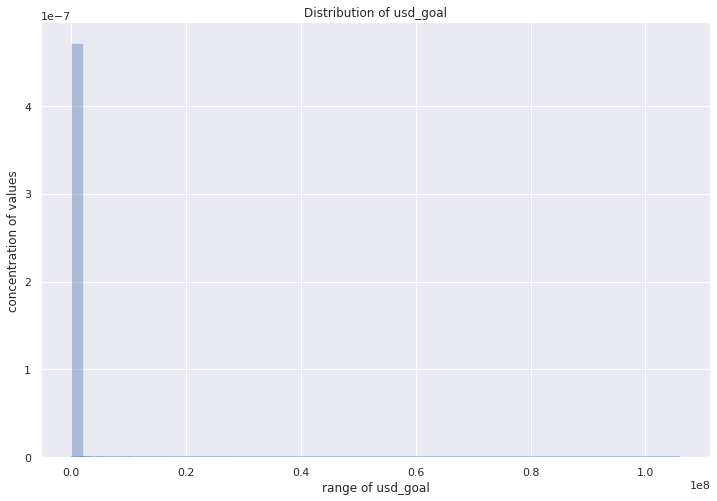

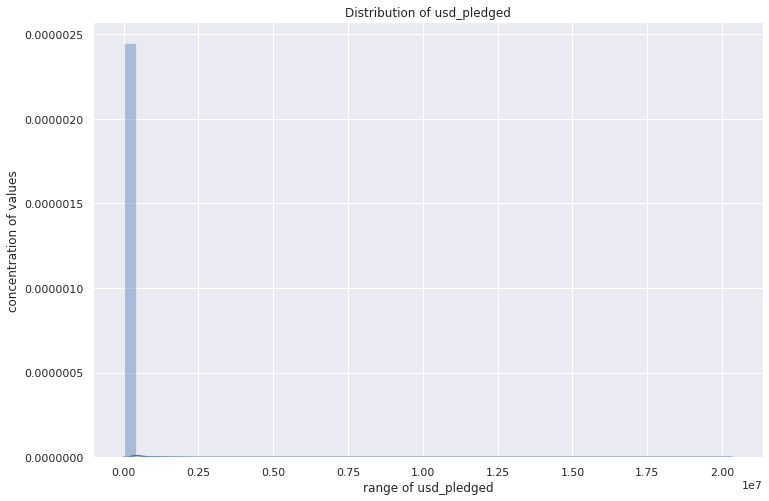

In [0]:
# Plot distributions of potential target data.
# 'state' is categorical and, therefore, not considered as a target.
gr_cols = ['usd_goal', 'usd_pledged']

for col in gr_cols:
    plt.figure(figsize=(12,8))
    sns.distplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'range of {col}')
    plt.ylabel('concentration of values')
    
    plt.show()


As expected, each plot shows extreme outlier data causing high amount of skew and kurtosis.  Given the extremeness of outlier data and a high concentration of data near zero, normalization may prove difficult.  

For the business case, there is little interest in  campaigns generating zero dollars pledged.  It may make sense to remove observations of zero dollars pledged.  More exploration is necessary to determine a strategy for handling outliers.

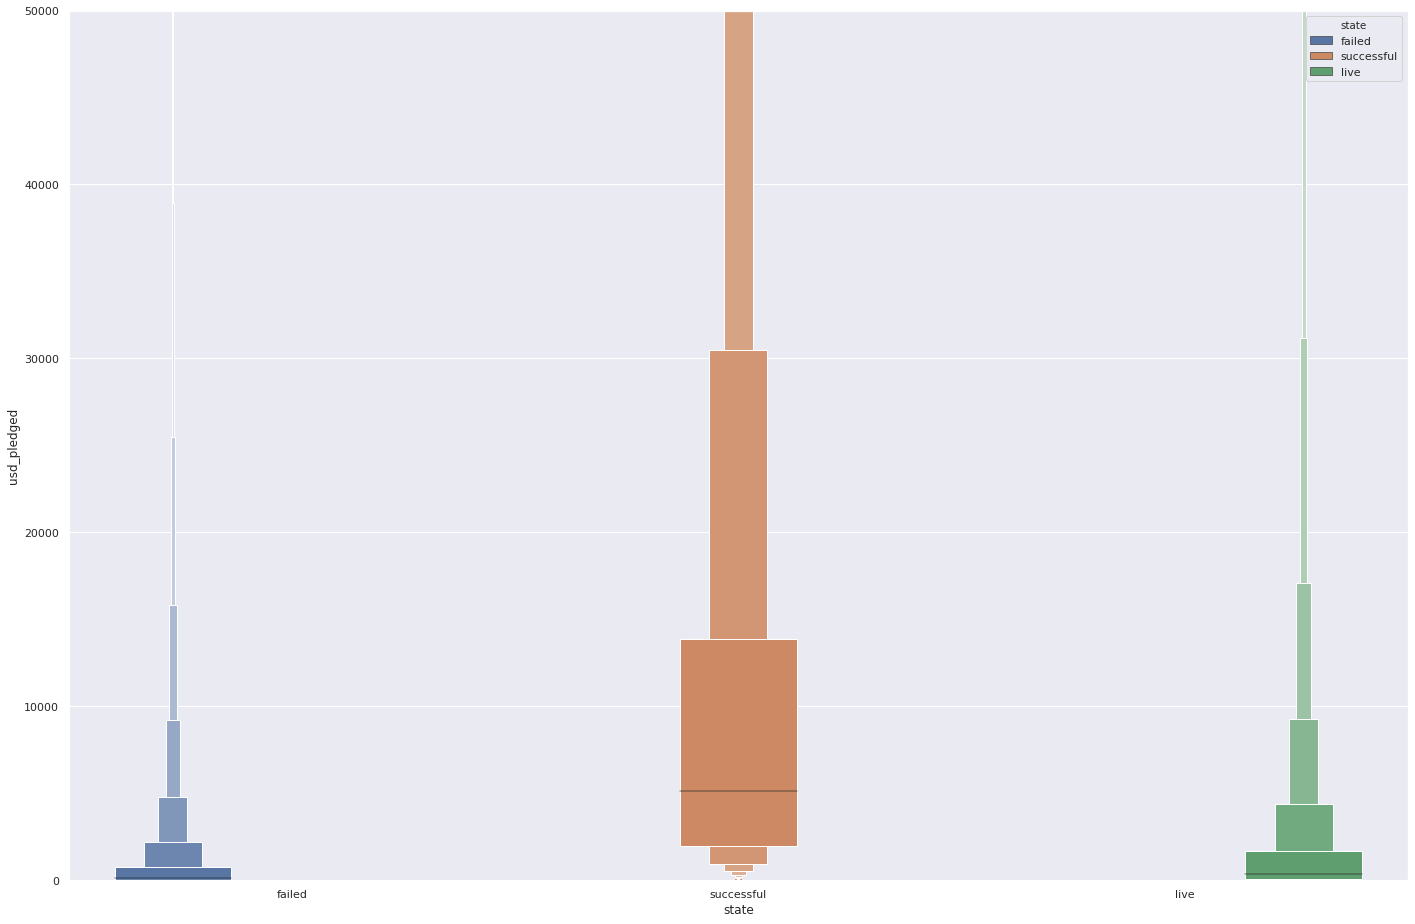

In [0]:
plt.figure(figsize=(24,16))
sns.boxenplot(df['state'], df['usd_pledged'], hue=df['state'], )
plt.ylim((0, 50000))
plt.show()

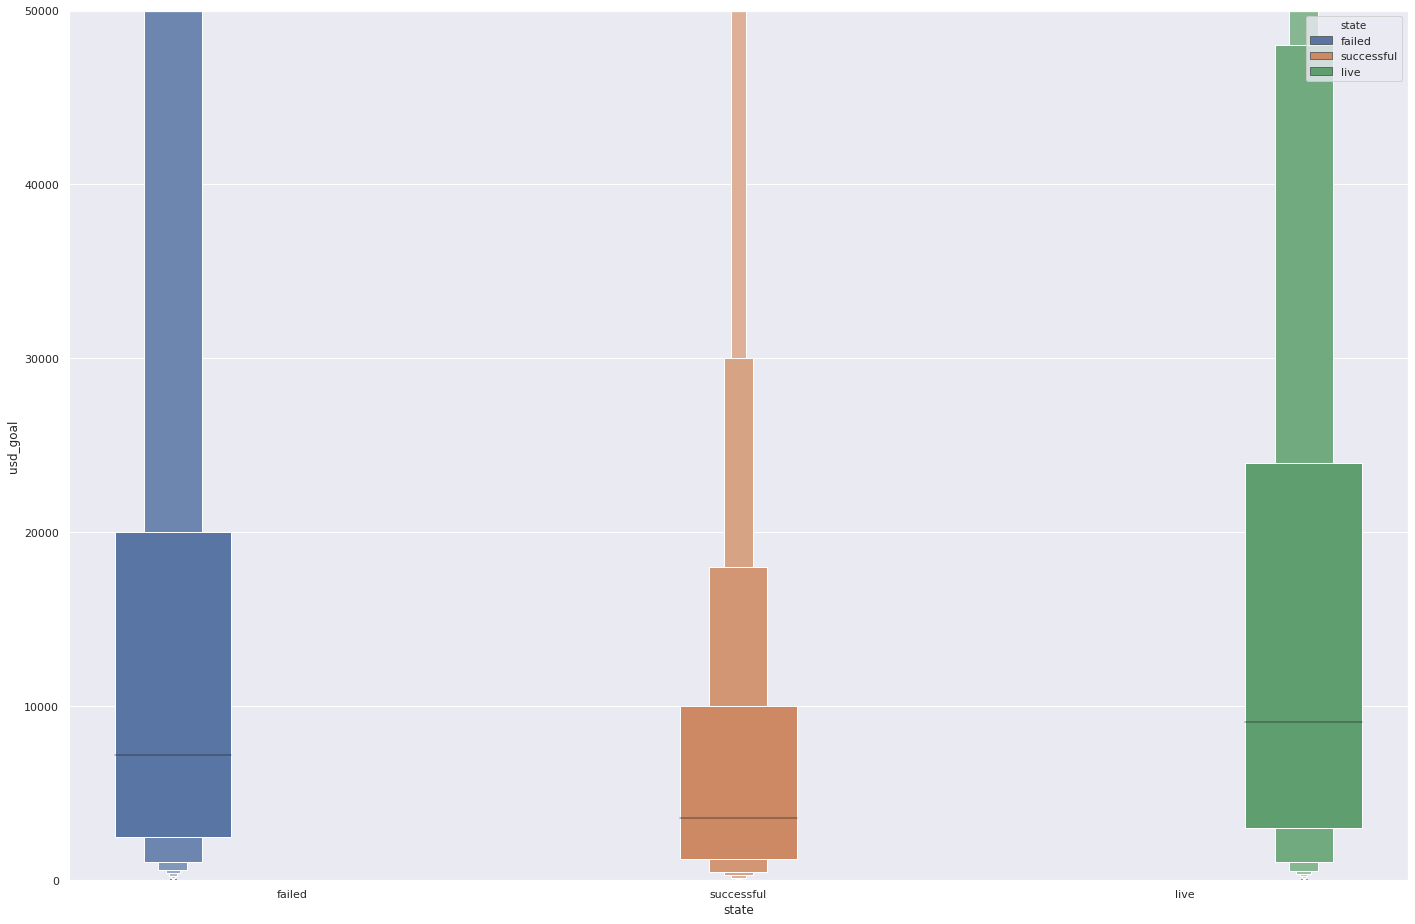

In [0]:
plt.figure(figsize=(24,16))
sns.boxenplot(df['state'], df['usd_goal'], hue=df['state'], )
plt.ylim((0, 50000))
plt.show()

In [0]:
print(df['usd_goal'][df['state']=='successful'].quantile(.9375))
print(df['usd_goal'][df['state']=='successful'].quantile(.0525))
print(df['usd_goal'][df['state']=='failed'].quantile(.9375))
print(df['usd_goal'][df['state']=='failed'].quantile(.0525))
print(df['usd_goal'][df['state']=='live'].quantile(.9375))
print(df['usd_goal'][df['state']=='live'].quantile(.0525))


30000.0
257.1006647749999
89201.14221875001
500.0
75000.0
500.0


In [0]:
print(df['usd_pledged'][df['state']=='successful'].quantile(.9375))
print(df['usd_pledged'][df['state']=='successful'].quantile(.0525))
print(df['usd_pledged'][df['state']=='failed'].quantile(.9375))
print(df['usd_pledged'][df['state']=='failed'].quantile(.0525))
print(df['usd_pledged'][df['state']=='live'].quantile(.9375))
print(df['usd_pledged'][df['state']=='live'].quantile(.0525))


61160.89770894313
495.0
4798.50769509375
1.0
9279.5781863025
1.0


<center><strong>Goal and Pledge ranges of percentile 5.25-93.75 of each Campaign state</strong></center>

<style>
table { 
  display: table;
  border-collapse: separate;
  border-spacing: 20px;
  border-color: blue;
}
</style>
<table width="800">
 <tr>
   <th height="50"><font size="4">State</font></th>
   <th><font size="4">Goal Range</font></th>
   <th><font size="4">Pledge Range (usd)</font></th>
 </tr>
 <tr>
   <td height="50"><font size="3">Successful</font></td>
   <td><center><font size="2.5">257   -   30,000</font></center></td>
   <td><center><font size="2.5">495    -    61,161</center></td>
 </tr>
 
  <tr>
   <td height="50"><font size="3">Failed</font></td>
   <td><center><font size="2.5">500   -   93,140</font></center></td>
   <td><center><font size="2.5">0    -    3,837</center></td>
 </tr>
  <tr>
   <td height="50"><font size="3">Live</font></td>
   <td><center><font size="2.5">500   -   75,576</font></center></td>
   <td><center><font size="2.5">0    -    8,414</center></td>
 </tr>
</table>


Given that a sucessful campaign is defined as one that meets it's pledge goals, it is reasonably noted that successful campaigns generate more reveneue than all other classes.  Of particular interest, however, are the goals per class.  The average goal of successful campaigns, and even variance of goals, is well below all other campaign 'state'.  

One potential insight may be that setting the appropriate goal is a reasonable indicator of success.  Additionally, the table displays a range of goals that has a reasonable amount of overlap.  This may indicate that other factors (such as design, promotion, etc) play a significant role in success.

Given the business case is interested in identifying features of successful campaigns and predicting the pledge amounts of campaigns, this data provides a means to trim the dataset and remove outliers.  Data will be trimmed by the goal range for successful campaigns.  



In [0]:
df = df.loc[(df['usd_goal'] >= 257) & (df['usd_goal']<=30000)]
df.shape

(235750, 242)

In [0]:
#df['usd_pledged'].quantile(.9802)
df['usd_pledged'].describe()

count    2.357500e+05
mean     8.612209e+03
std      5.203082e+04
min      4.563543e-01
25%      2.470000e+02
50%      1.765000e+03
75%      6.300000e+03
max      9.192056e+06
Name: usd_pledged, dtype: float64

In [0]:
df['pg_rat'] = df['usd_pledged']/df['usd_goal']
df['pg_rat'].describe()

count    235750.000000
mean          1.412124
std           6.261277
min           0.000020
25%           0.063333
50%           1.013333
75%           1.230719
max         926.567010
Name: pg_rat, dtype: float64

In [0]:
df['usd_pledged'].quantile(.975)

47188.75562207245

In [0]:
df['winsorized_pledge'] = winsorize(df['usd_pledged'],limits=(0,0.025),)
df['winsorized_pledge'].describe()

count    235750.000000
mean       5854.293513
std        9947.311183
min           0.456354
25%         247.000000
50%        1765.000000
75%        6300.000000
max       47194.500000
Name: winsorized_pledge, dtype: float64

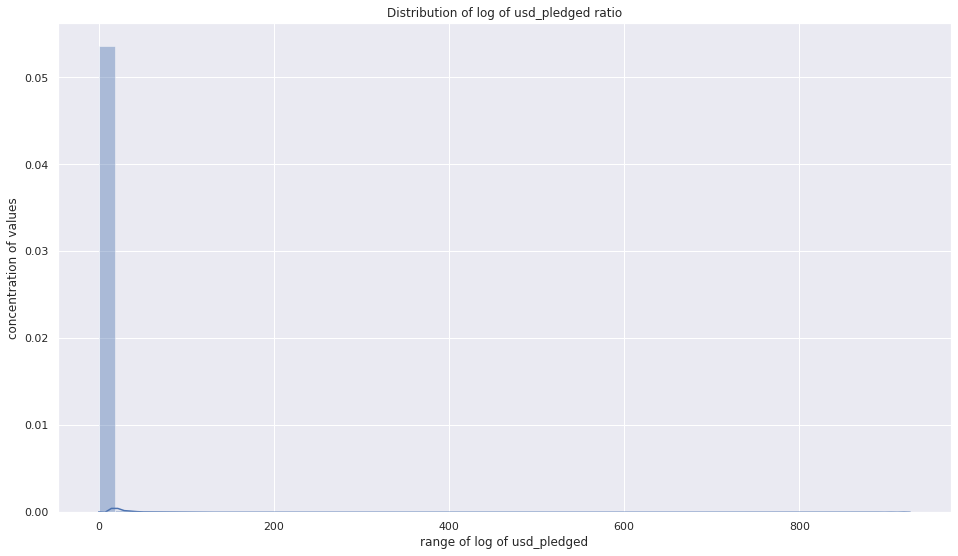

In [0]:
# plot comparison between 'usd_pledged' and 'usd_goal'
plt.figure(figsize=(16,9))
sns.distplot(df['pg_rat'])

plt.title('Distribution of log of usd_pledged ratio')
plt.xlabel('range of log of usd_pledged')
plt.ylabel('concentration of values')


plt.show()

In [0]:
df['pg_rat'].describe()

count    235750.000000
mean          1.412124
std           6.261277
min           0.000020
25%           0.063333
50%           1.013333
75%           1.230719
max         926.567010
Name: pg_rat, dtype: float64

In [0]:
df = df.loc[df['pg_rat']<=3]
df.shape

(219291, 244)

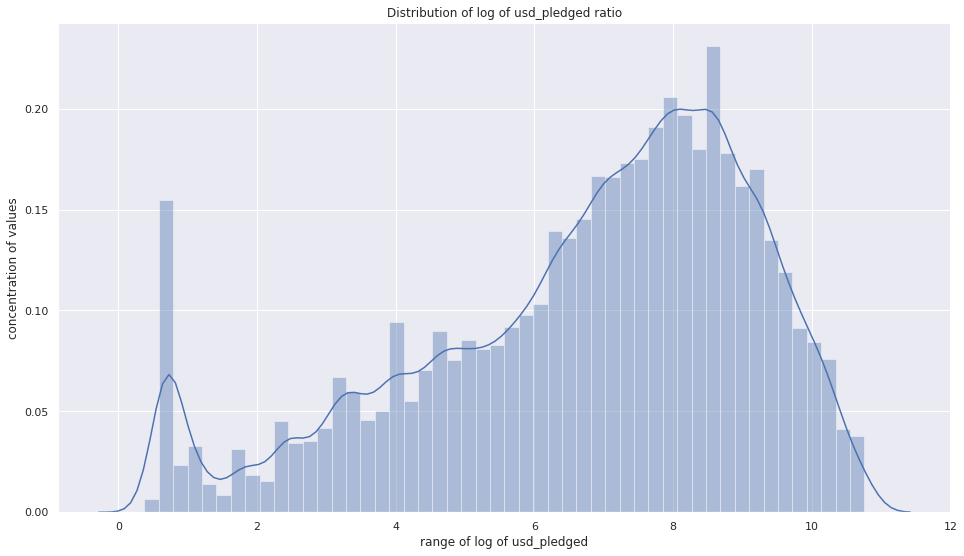

In [0]:
# plot comparison between 'usd_pledged' and 'usd_goal'
plt.figure(figsize=(16,9))
sns.distplot(np.log1p(df['winsorized_pledge']))

plt.title('Distribution of log of usd_pledged ratio')
plt.xlabel('range of log of usd_pledged')
plt.ylabel('concentration of values')


plt.show()

Over the trimmmed range, the log of data, while not normally distributed, will be useful for prediction of the target.  

### Data-time Data

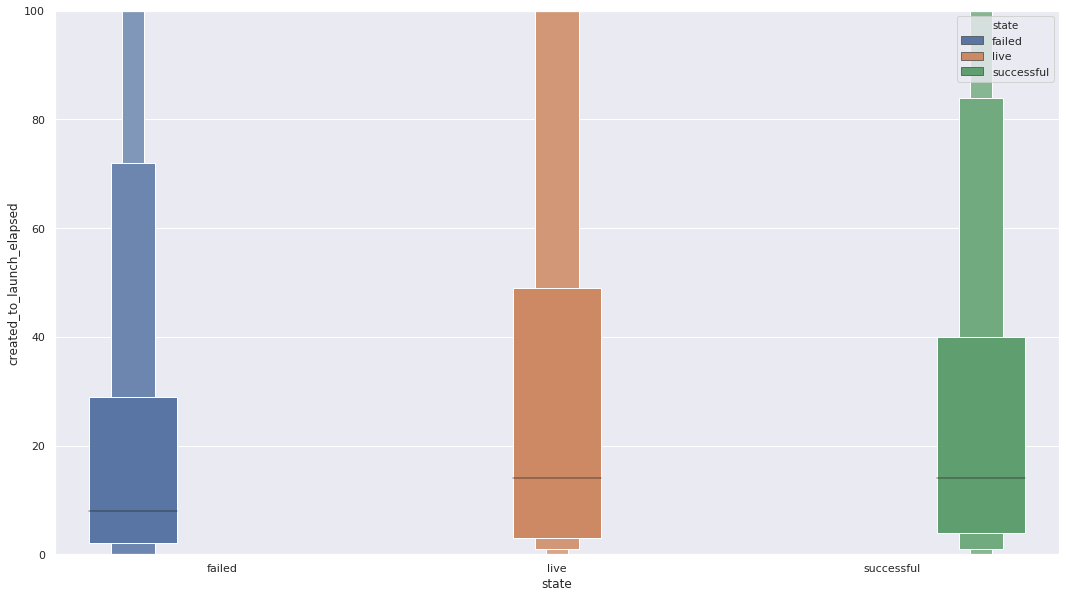

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['created_to_launch_elapsed'], hue=df['state'], )
plt.ylim((0, 100))
plt.show()

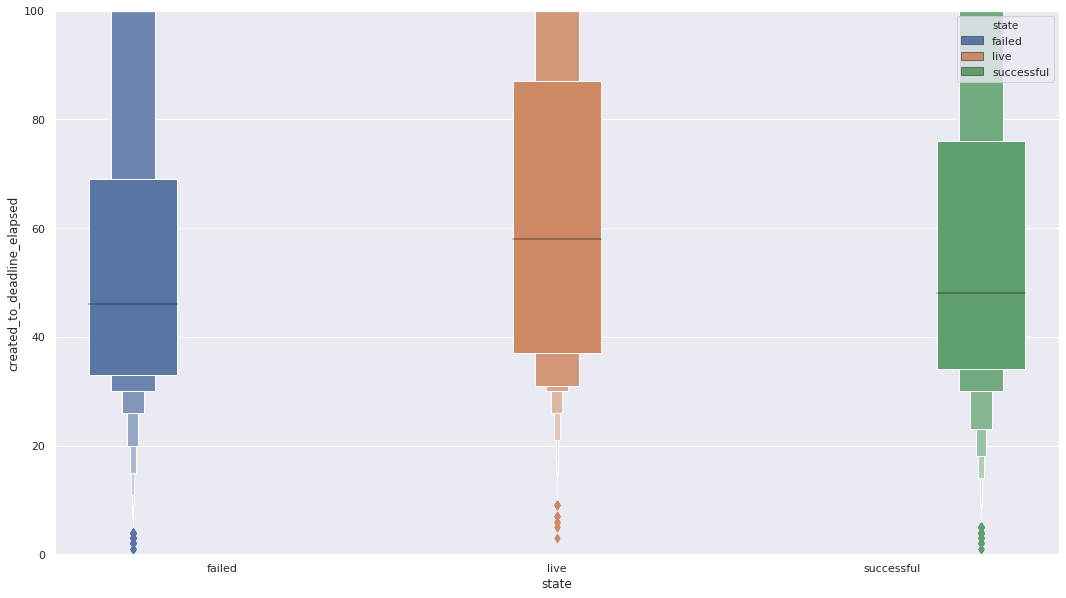

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['created_to_deadline_elapsed'], hue=df['state'], )
plt.ylim((0, 100))
plt.show()

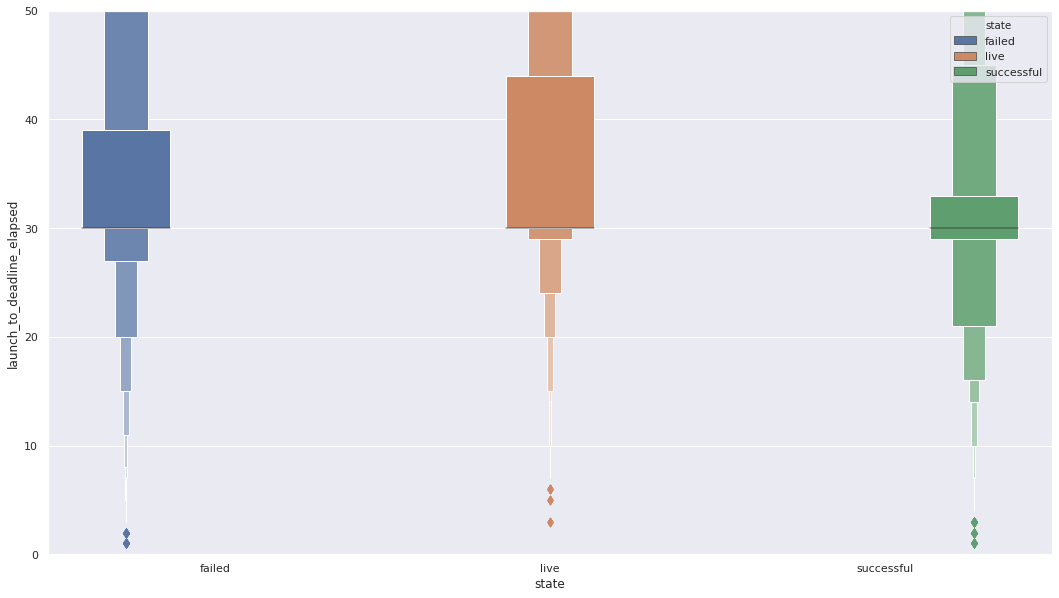

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['launch_to_deadline_elapsed'], hue=df['state'], )
plt.ylim((0, 50))
plt.show()

Plots indicate successful campaigns tend to have a longer "run-up" time prior to launch.  This may indicate a vital promotion time that lends to successful revenue generation.

Text(0.5, 1, 'Correlation of potential features')

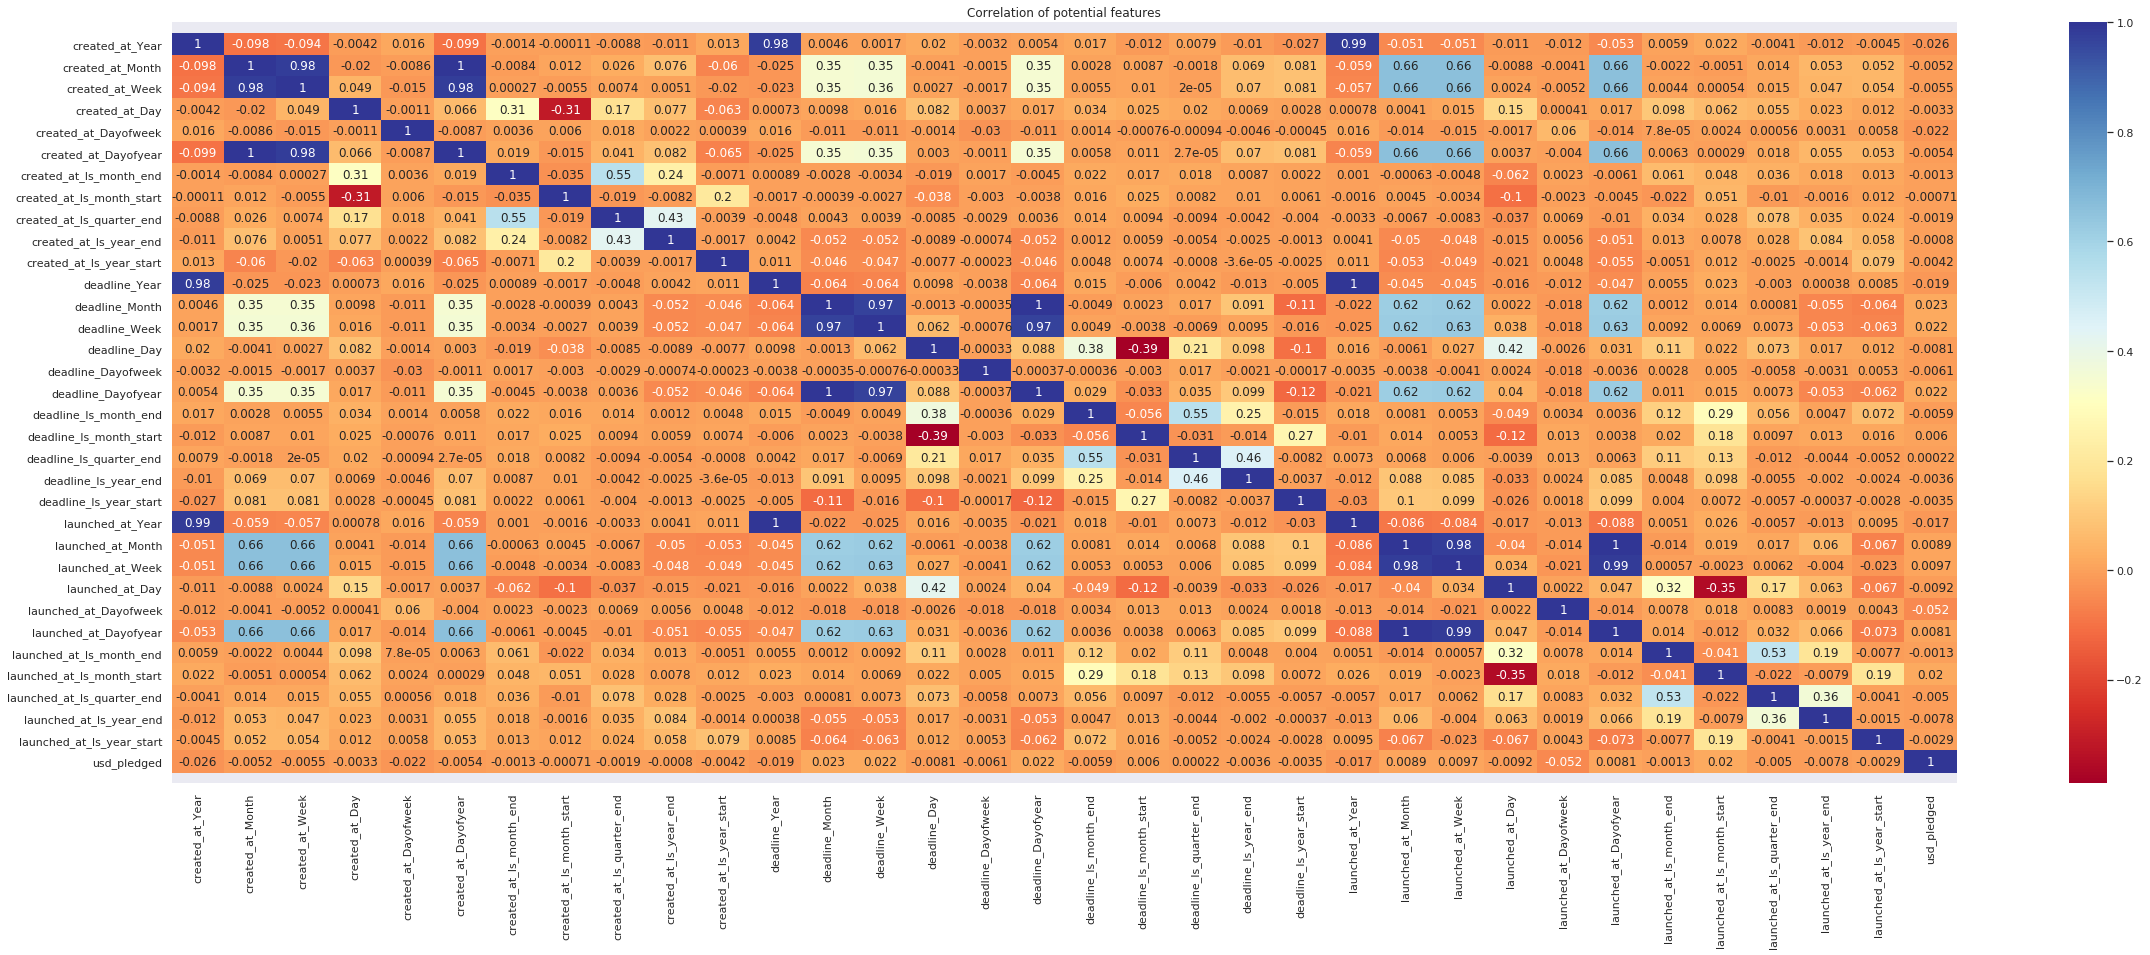

In [0]:
date_cols = ['created_at_Year', 'created_at_Month', 
             'created_at_Week', 'created_at_Day', 'created_at_Dayofweek',  
             'created_at_Dayofyear', 'created_at_Is_month_end', 
             'created_at_Is_month_start', 'created_at_Is_quarter_end', 
             'created_at_Is_year_end', 'created_at_Is_year_start', 'deadline_Year', 
             'deadline_Month', 'deadline_Week', 'deadline_Day', 'deadline_Dayofweek', 
             'deadline_Dayofyear', 'deadline_Is_month_end', 'deadline_Is_month_start', 
             'deadline_Is_quarter_end', 'deadline_Is_year_end', 
             'deadline_Is_year_start', 'launched_at_Year', 'launched_at_Month', 
             'launched_at_Week', 'launched_at_Day', 'launched_at_Dayofweek',
             'launched_at_Dayofyear', 'launched_at_Is_month_end', 
             'launched_at_Is_month_start', 'launched_at_Is_quarter_end', 
             'launched_at_Is_year_end', 'launched_at_Is_year_start', 'usd_pledged']

date_df = df[date_cols]

# View Feature correlation
plt.figure(figsize=(40,14))
ax = sns.heatmap(date_df.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

Date specific data does not appear to show notable correlation with the target.

### Backers

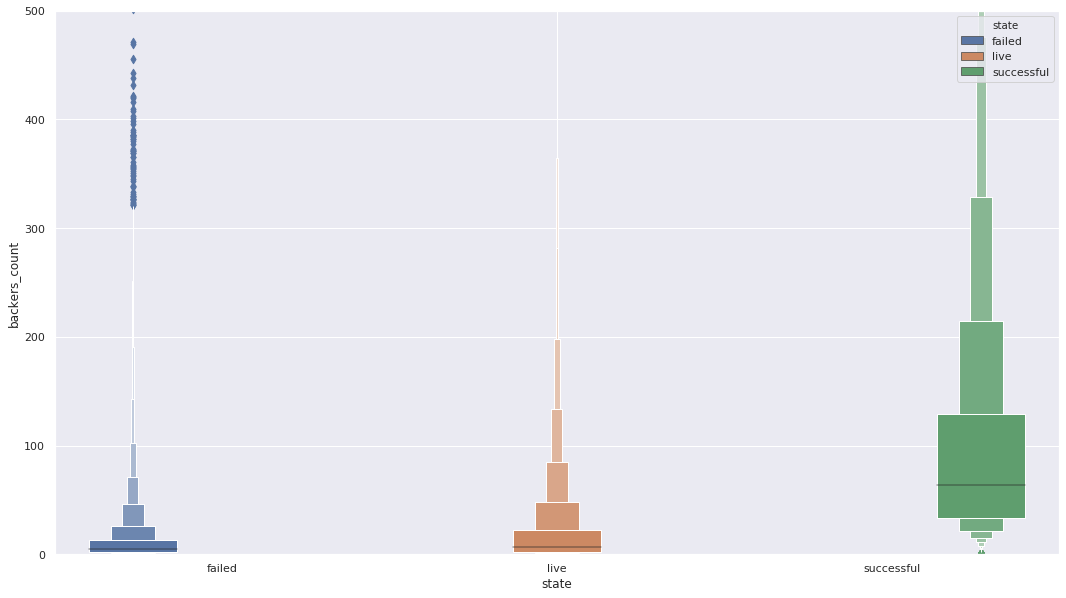

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['backers_count'], hue=df['state'], )
plt.ylim((0, 500))
plt.show()

An immediate insight:  <strong>Backers are a strong indicator of success.</strong>

This seems as though it would be a hindsight statistic, however, information exists within the data that implies that knowledge of potential backers is not necessarily ex post facto.  
* 'created_at' - Defines the date the campaign is registered with Kickstarter.  This does not indicate a live campaign, rather it is a delcaration of the intent to launch a campaign.
* 'launched_at' - Defines the date the campaign is live and accepting pledges.  

Domain research confirms that once a campaign is created, a preview link is provided.  While the campaign is not live, a link to the preview page may be provided to potential backers.  Hence, a reasonable estimation of backers may be attainable.  While developing and executing a marketing strategy may occur before campaign creation, the amount of time between creation and launch is measureable; and may provide useful information.

### Text Data  

The 'blurb' column may hold several nuggets of information; especially when it comes to sentiment.  While sentiment will not be explored at this time, other attributes of text will be evaluated:
* word count
* syllable count

Assumption:  From a marketing perspective, the goal would be to convey a message concisely.  This premise may indicate that word counts and syllable counts may serve as basic evaluation of message complexity. 


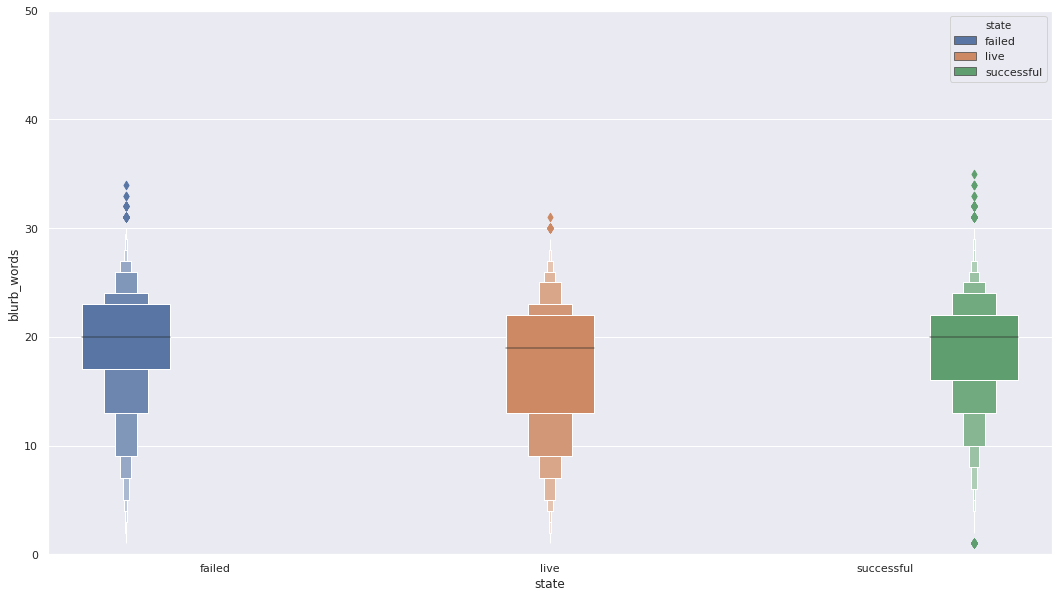

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['blurb_words'], hue=df['state'], )
plt.ylim((0, 50))
plt.show()

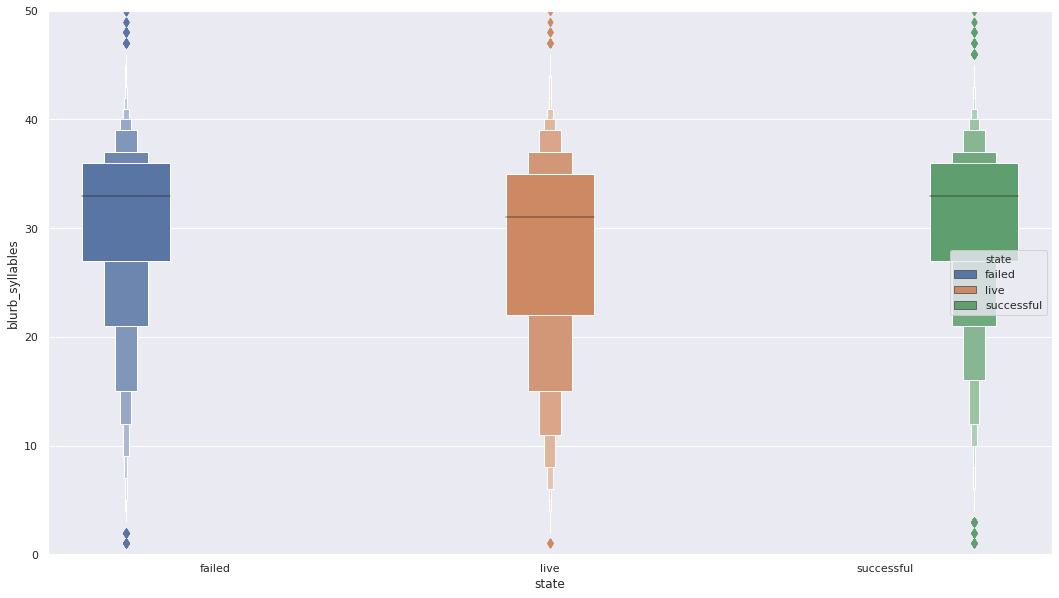

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['blurb_syllables'], hue=df['state'], )
plt.ylim((0, 50))
plt.show()

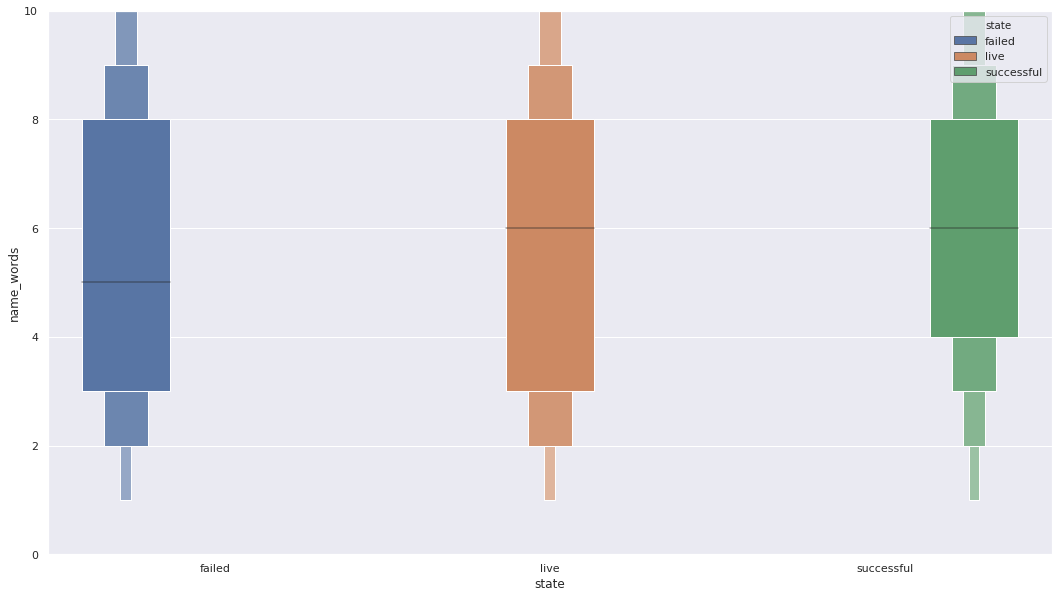

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['name_words'], hue=df['state'], )
plt.ylim((0, 10))
plt.show()

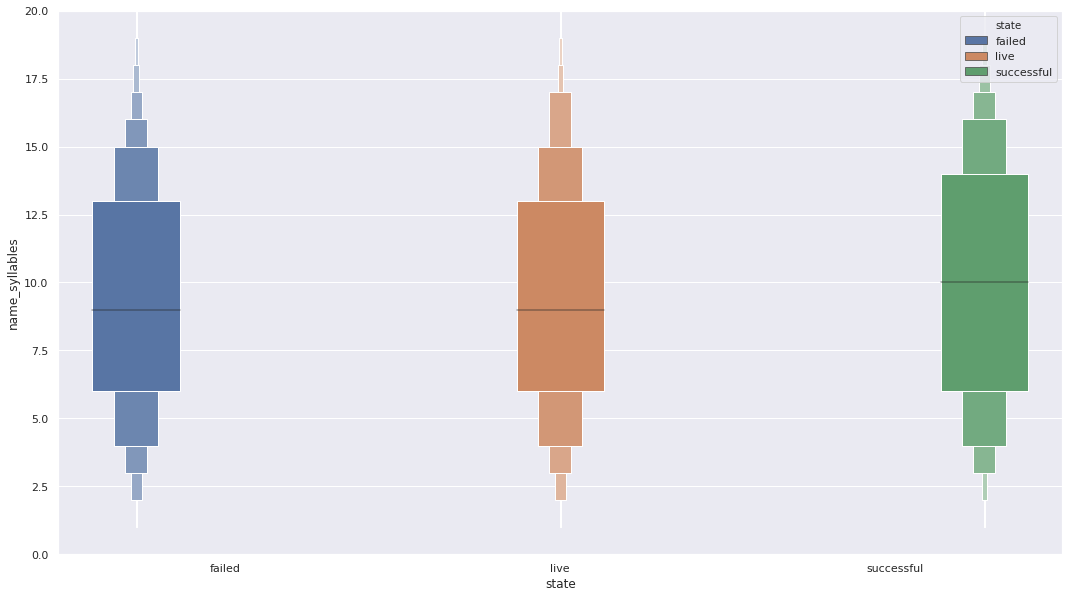

In [0]:
plt.figure(figsize=(18,10))
sns.boxenplot(df['state'], df['name_syllables'], hue=df['state'], )
plt.ylim((0, 20))
plt.show()

Basic 'blurb' statistics do not demonstrate much differentiation with states.  The 'name' text statistics, however, shows separation of successful from other states.  This may indicate that the number of words in a name is a predictor. 

### Categorical Data  


In [0]:
# Organize categorical data to evaluate correlation with target
countries = ['AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 
             'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 'NZ', 'SE', 'SG', 'US', 
             'usd_pledged']

parent_cats = ['pcat_comics', 'pcat_crafts', 'pcat_dance', 'pcat_design', 
               'pcat_fashion', 'pcat_film & video', 'pcat_food','pcat_games', 
               'pcat_journalism', 'pcat_music', 'pcat_photography', 
               'pcat_publishing', 'pcat_technology', 'pcat_theater', 'usd_pledged']

subcats = ['subcat_academic', 'subcat_accessories', 'subcat_action', 
           'subcat_animals', 'subcat_animation', 'subcat_anthologies', 
           'subcat_apparel', 'subcat_apps', 'subcat_architecture', 'subcat_art', 
           'subcat_art books', 'subcat_audio', 'subcat_bacon', 'subcat_blues', 
           'subcat_calendars', 'subcat_camera equipment', 'subcat_candles', 
           'subcat_ceramics', "subcat_children's books", 'subcat_childrenswear', 
           'subcat_chiptune', 'subcat_civic design', 'subcat_classical music', 
           'subcat_comedy', 'subcat_comic books', 'subcat_comics', 
           'subcat_community gardens', 'subcat_conceptual art', 'subcat_cookbooks', 
           'subcat_country & folk', 'subcat_couture', 'subcat_crafts', 
           'subcat_crochet', 'subcat_dance', 'subcat_design', 'subcat_digital art', 
           'subcat_diy', 'subcat_diy electronics', 'subcat_documentary', 
           'subcat_drama', 'subcat_drinks', 'subcat_electronic music', 
           'subcat_embroidery', 'subcat_events', 'subcat_experimental', 
           'subcat_fabrication tools', 'subcat_faith', 'subcat_family', 
           'subcat_fantasy', "subcat_farmer's markets", 'subcat_farms', 
           'subcat_fashion', 'subcat_festivals', 'subcat_fiction', 
           'subcat_film & video', 'subcat_fine art', 'subcat_flight', 'subcat_food', 
           'subcat_food trucks', 'subcat_footwear', 'subcat_gadgets', 'subcat_games', 
           'subcat_gaming hardware', 'subcat_glass', 'subcat_graphic design', 
           'subcat_graphic novels', 'subcat_hardware', 'subcat_hip-hop', 'subcat_horror', 
           'subcat_illustration', 'subcat_immersive', 'subcat_indie rock', 
           'subcat_installations', 'subcat_interactive design', 'subcat_jazz', 
           'subcat_jewelry', 'subcat_journalism', 'subcat_kids', 'subcat_knitting', 
           'subcat_latin', 'subcat_letterpress', 'subcat_literary journals', 
           'subcat_literary spaces', 'subcat_live games', 'subcat_makerspaces', 
           'subcat_metal', 'subcat_mixed media', 'subcat_mobile games', 
           'subcat_movie theaters', 'subcat_music', 'subcat_music videos', 
           'subcat_musical', 'subcat_narrative film', 'subcat_nature', 
           'subcat_nonfiction', 'subcat_painting', 'subcat_people', 
           'subcat_performance art', 'subcat_performances', 'subcat_periodicals', 
           'subcat_pet fashion', 'subcat_photo', 'subcat_photobooks', 'subcat_photography',  
           'subcat_places', 'subcat_playing cards', 'subcat_plays', 'subcat_poetry', 
           'subcat_pop', 'subcat_pottery', 'subcat_print', 'subcat_printing', 
           'subcat_product design', 'subcat_public art', 'subcat_publishing', 
           'subcat_punk', 'subcat_puzzles', 'subcat_quilts', 'subcat_r&b', 
           'subcat_radio & podcasts', 'subcat_ready-to-wear', 'subcat_residencies', 
           'subcat_restaurants', 'subcat_robots', 'subcat_rock', 'subcat_romance', 
           'subcat_science fiction', 'subcat_sculpture', 'subcat_shorts', 
           'subcat_small batch', 'subcat_social practice', 'subcat_software', 
           'subcat_sound', 'subcat_space exploration', 'subcat_spaces', 'subcat_stationery', 
           'subcat_tabletop games', 'subcat_taxidermy', 'subcat_technology', 
           'subcat_television', 'subcat_textiles', 'subcat_theater', 'subcat_thrillers', 
           'subcat_translations', 'subcat_typography', 'subcat_vegan', 'subcat_video', 
           'subcat_video art', 'subcat_video games', 'subcat_wearables', 'subcat_weaving', 
           'subcat_web', 'subcat_webcomics', 'subcat_webseries', 'subcat_woodworking', 
           'subcat_workshops', 'subcat_world music', 'subcat_young adult', 
           'subcat_zines', 'usd_pledged']

cntry = df[countries]
prnts = df[parent_cats]
sbcts = df[subcats]

Text(0.5, 1, 'Correlation of potential features')

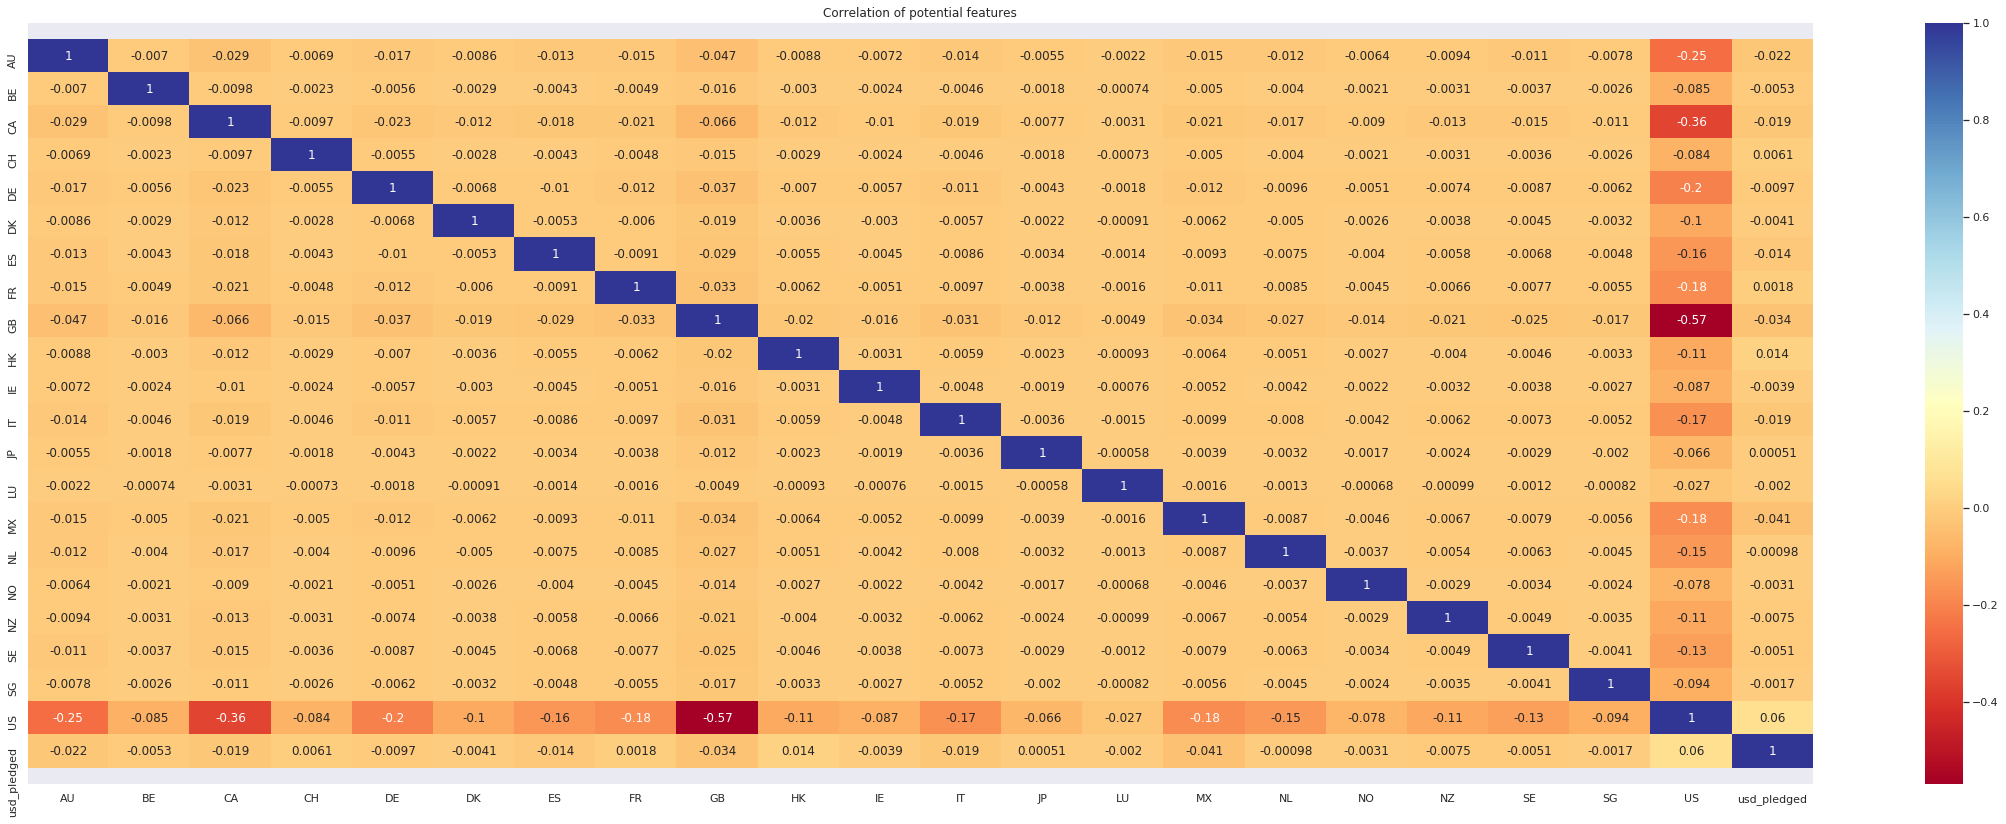

In [0]:
# View Feature correlation
plt.figure(figsize=(40,14))
ax = sns.heatmap(cntry.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

Text(0.5, 1, 'Correlation of potential features')

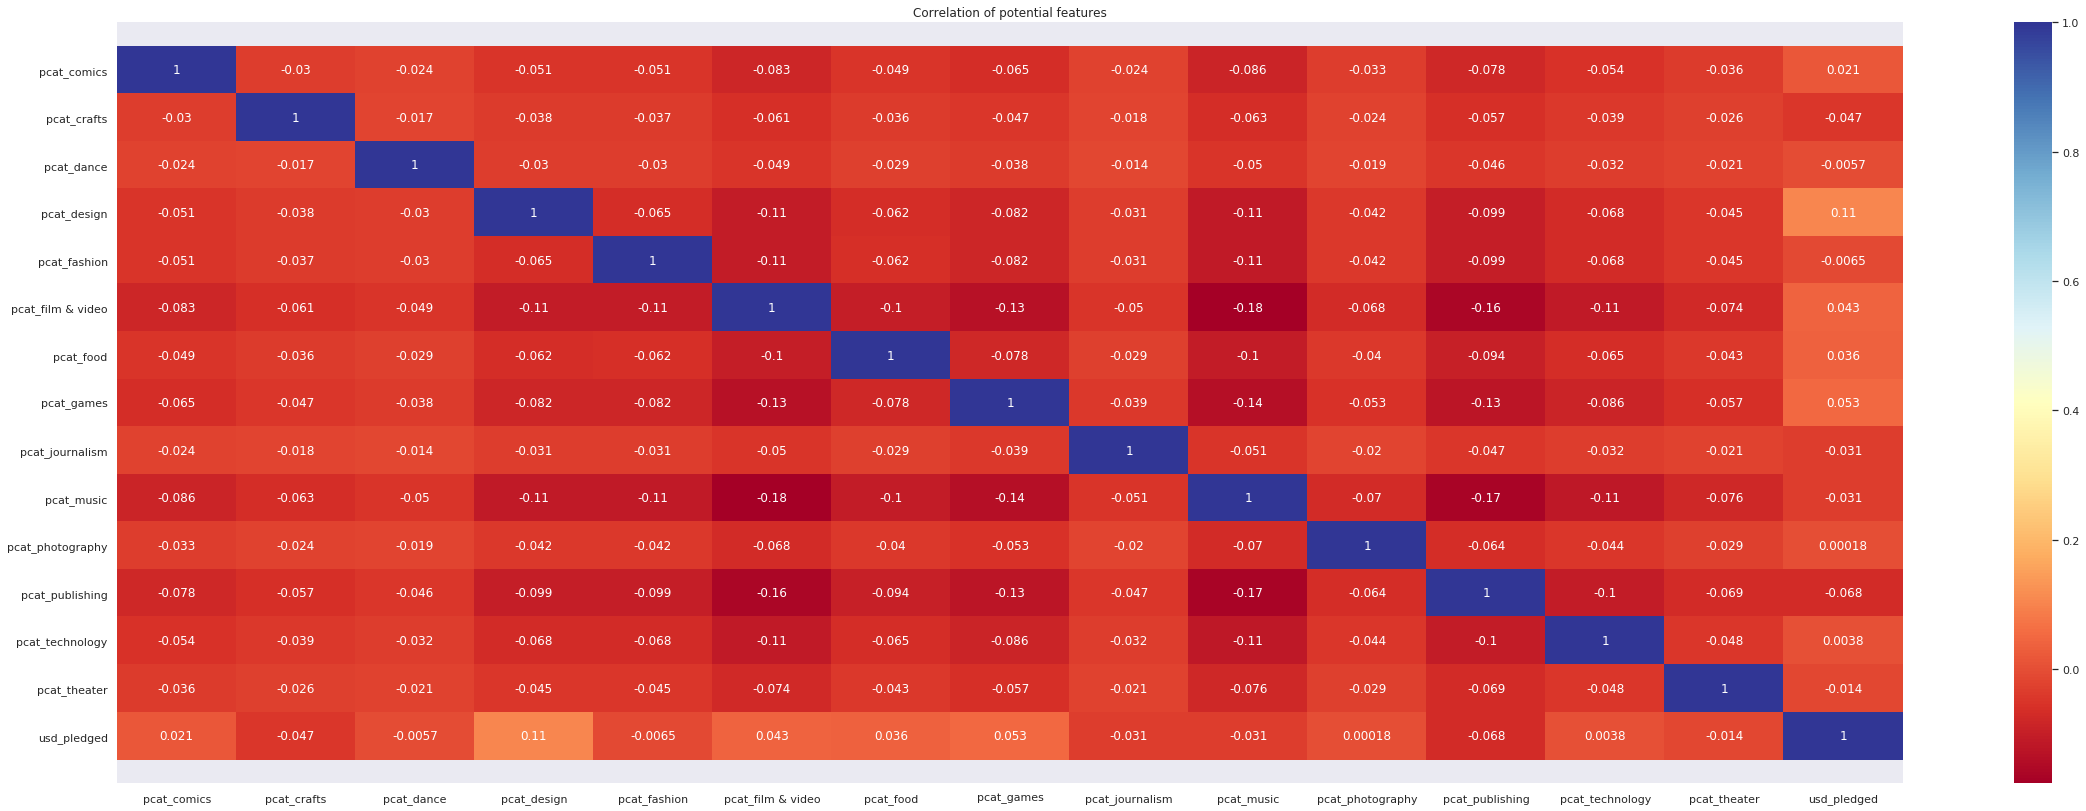

In [0]:
# View Feature correlation
plt.figure(figsize=(40,14))
ax = sns.heatmap(prnts.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

In [0]:
# View Feature correlation
plt.figure(figsize=(160,80))
ax = sns.heatmap(sbcts.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

Categorical data appears to demonstrate almost no notable correlation with target data.  While there are varying leanings of positive and negative correlation, the scores are near enough to zero that they may be limited in their predictability.  

Furthermore, in the large majority of cases, categorical features do not express colinearity.  This, and that data are categorical, will limit the usefulness of principal component analysis (PCA) as a dimensionality reduction technique.  Other methods may need to be explored and/or feature selection must be discriminant.

### Finish Cleaning and Save

In [0]:
# check dtypes
df.get_dtype_counts()

bool        18
float64      5
int64      220
object       1
dtype: int64

In [0]:
# convert applicable 'int64' dtypes to bool and category types
for column in df.columns:
    if df[column].dtype.name == 'int64':
        if 'cat' in column or len(column) == 2:
            df[column] = df[column].astype(bool)
        elif 'at' in column or 'deadline' in column:
            if 'elapsed' not in column:
                df[column] = df[column].astype('category')

df.get_dtype_counts()


category     18
bool        212
float64       5
int64         8
object        1
dtype: int64

In [0]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['backers_count', 'static_usd_rate', 'usd_pledged', 'usd_goal',
       'created_to_launch_elapsed', 'created_to_deadline_elapsed',
       'launch_to_deadline_elapsed', 'blurb_syllables', 'blurb_words',
       'name_syllables', 'name_words', 'pg_rat', 'winsorized_pledge'],
      dtype='object')

In [0]:
# Initialize a transformation dictionary for data
transform = {'static_usd_rate':df['static_usd_rate'], 
             'created_to_launch_elapsed':np.log1p(df['created_to_launch_elapsed']),
             'created_to_deadline_elapsed':np.log1p(df['created_to_deadline_elapsed']),
             'blurb_syllables':df['blurb_syllables'],
             'name_syllables':df['name_syllables'],
             'usd_goal':np.log1p(df['usd_goal']), 
             'backers_count':np.log1p(df['backers_count']),
             'usd_pledged': np.log1p(df['usd_pledged']),
             'launch_to_deadline_elapsed':np.log1p(df['launch_to_deadline_elapsed']),
             'blurb_words':df['blurb_words'],
             'name_words':df['name_words'],
             'pg_rat':df['pg_rat'], 
             'winsorized_pledge':np.log1p(df['winsorized_pledge'])}

In [0]:
for column in df.columns:
    if column in list(transform.keys()):
        df[column] = transform.get(column)

In [0]:
df.drop(columns=['pg_rat'], axis=1, inplace=True)

In [0]:
# save second clean version of data
path2 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data_2b.csv'
df.to_csv(path2)

## Feature Selection

With the large number of features, and with many of the features showing virtually no correlation with the target variable, a naive approach to feature selection will utilized.  

This step has been performed in a supplementary workbook linked below.  In this case, a Random Forest Model, with n_estimater=10, was used to evaluate and return feature importances.  

Data was split into continuous and categorical variables and evaluated separately.  After determining the most predictive features, other feature data was discarded from each set.  Finally, the continuous and categorical were combined for modeling.

<strong>Link:</strong>

https://colab.research.google.com/drive/1nC82pI5iQiwtszfeyWsPC-IvteMd69Qt

## Model Selection

After features have been selected, modeling can be performed.  Since feature selection has been performed in another notebook, the model-ready data must be loaded and preprocessing should be performed.

### Preprocessing

In [0]:
# Load cleaned data with pre-selected features
path3 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data_3b.csv'

df = pd.read_csv(path3)

In [0]:
# check dtypes
df.get_dtype_counts()

float64     7
int64      23
bool       56
dtype: int64

In [0]:
# data types need to be corrected before preprocessing
for column in df.columns:
    if df[column].dtype.name == 'int64':
        if 'cat' in column or len(column) == 2:
            df[column] = df[column].astype(bool)
        elif 'at' in column or 'deadline' in column:
            if 'elapsed' not in column:
                df[column] = df[column].astype('category')

df.get_dtype_counts()

category    18
bool        56
float64      7
int64        5
dtype: int64

In [0]:
# Initialize feature and target & split into train and test sets
X = df.drop(columns=['Unnamed: 0', 'winsorized_pledge'])
y = df['winsorized_pledge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

### Compare Models

The feature selection method involved identifying low importance features.  These features were discarded.  Given the intent to use tree based models, features not identified as low importance were kept as-is without the use of dimensionality reduction.  

The following will compare the performance of three tree-based, ensemble, models.  These models generally perform better than linear and logistic regression models since they use multiple "learners" to model data.  Another benefit is that tree-based models are generally not affected by colinearity.  The following models will be compared:

* Random Forest Regressor
* Gradient Boosting Regressor
* XGB Regressor

In [0]:
# Fit and evaluate un-tuned models to form a baseline.
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xb = XGBRegressor()

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
xb.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
xb_pred = xb.predict(X_test)

[04:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
print(model_scorer(np.expm1(y_test), np.expm1(rf_pred), 'Random Forest', ['mae']))
print(model_scorer(np.expm1(y_test), np.expm1(gb_pred), 'Gradient Boosting', ['mae']))
print(model_scorer(np.expm1(y_test), np.expm1(xb_pred), 'XGB Regressor', ['mae']))

------- Random Forest Model Eval. -------
Mean Absolute Error:  1210.2435278844987
None
------- Gradient Boosting Model Eval. -------
Mean Absolute Error:  1481.9470076674163
None
------- XGB Regressor Model Eval. -------
Mean Absolute Error:  1484.1460916185063
None


### Compare Tuned Models

Based on the Mean Absolute Error, the Random Forest model performs better.  The initial run is based on default, untuned settings, and final evaluation will be revisited after tuning is complete.  

Due to computational limits, models were tuned separately in notebooks linked below.  Tuning of each model was performed on a random subsample of the overall dataset (15,000 observations).  

GridSearch techniques were not effective with XGB Regressor and Gradient Boosting Regressor models as they tended to crash the notebook's runtime.  As an alternative, hyperparameters were tuned by evaluating validation curve data.


<strong>Links:</strong>

https://colab.research.google.com/drive/1RgwjhiYQ4K-GyaB7GNg2jJMGepL-SPgM

https://colab.research.google.com/drive/1Lm66hMXsUQJLID2mN8sqKwR5vD942SoW

https://colab.research.google.com/drive/1kKlTJhI_KuJ4NaoC_XAwisvl5Ur-1bA8

In [0]:
# Initialize models with hyperparameters identified during tuning
rf = RandomForestRegressor(max_features='auto', min_samples_leaf=1, 
                           min_samples_split=2, n_estimators=100)

gb = GradientBoostingRegressor(n_estimators=350, max_depth=7, 
                               min_samples_split=0.1, min_samples_leaf=1,
                               max_features=0.9, learning_rate=0.05)

xb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, 
                  subsample=0.9, colsample_bytree=0.9, gamma=0, 
                  objective='reg:tweedie')

# fit models
rf.fit(X_train,y_train)
gb.fit(X_train,y_train)
xb.fit(X_train,y_train)

# predict test data
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
xb_pred = xb.predict(X_test)

In [0]:
print(model_scorer(y_test, rf_pred, 'Random Forest', ['mae']))
print(model_scorer(y_test, gb_pred, 'GradientBoosting', ['mae']))
print(model_scorer(y_test, xb_pred, 'XGB', ['mae']))

------- Random Forest Model Eval. -------
Mean Absolute Error:  0.4145863876097278
None
------- GradientBoosting Model Eval. -------
Mean Absolute Error:  0.4230672557394368
None
------- XGB Model Eval. -------
Mean Absolute Error:  0.46502635741080633
None


In [0]:
print(model_scorer(np.expm1(y_test), np.expm1(rf_pred), 'Random Forest', ['mae']))
print(model_scorer(np.expm1(y_test), np.expm1(gb_pred), 'GradientBoosting', ['mae']))
print(model_scorer(np.expm1(y_test), np.expm1(xb_pred), 'XGB', ['mae']))

------- Random Forest Model Eval. -------
Mean Absolute Error:  1210.183635092417
None
------- GradientBoosting Model Eval. -------
Mean Absolute Error:  1278.2853069133607
None
------- XGB Model Eval. -------
Mean Absolute Error:  1820.3481678692597
None


## Implement Model

After tuning, model performance is as follows:

* Random Forest Model MAE:
 * initial model - 1210.24
 * tuned model - 1210.18
* Gradient Boosting Model MAE:
 * initial model - 1481.95
 * tuned model - 1278.29
* XGB Model MAE:
 * initial model - 1484.15
 * tuned model - 1820.35

Although showing very small improvement, the Random Forest Regressor is the best performer of the three models.  The Gradient Boosting model improved the most after tuning while the performance of the XGB model seemed to suffer.

The best performing model will be implemented.

In [0]:
model = RandomForestRegressor(max_features='auto', min_samples_leaf=1, 
                              min_samples_split=2, n_estimators=100)

model.fit(X_train, y_train)

predict = model.predict(X_test)

cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', 
                cv=5)

model_scorer(np.expm1(y_test), np.expm1(predict), 'Random Forest Regressor', 
             metric=['mae'])

------- Random Forest Regressor Model Eval. -------
Mean Absolute Error:  1211.5014991340179


In [0]:
model_scorer(y_test, predict, 'Random Forest Regressor', 
             metric=['mae'])

------- Random Forest Regressor Model Eval. -------
Mean Absolute Error:  0.4148118122611779


In [0]:
cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', 
                cv=5)

array([-0.4176255 , -0.41090066, -0.41314022, -0.41947644, -0.41441061])

## Conclusion


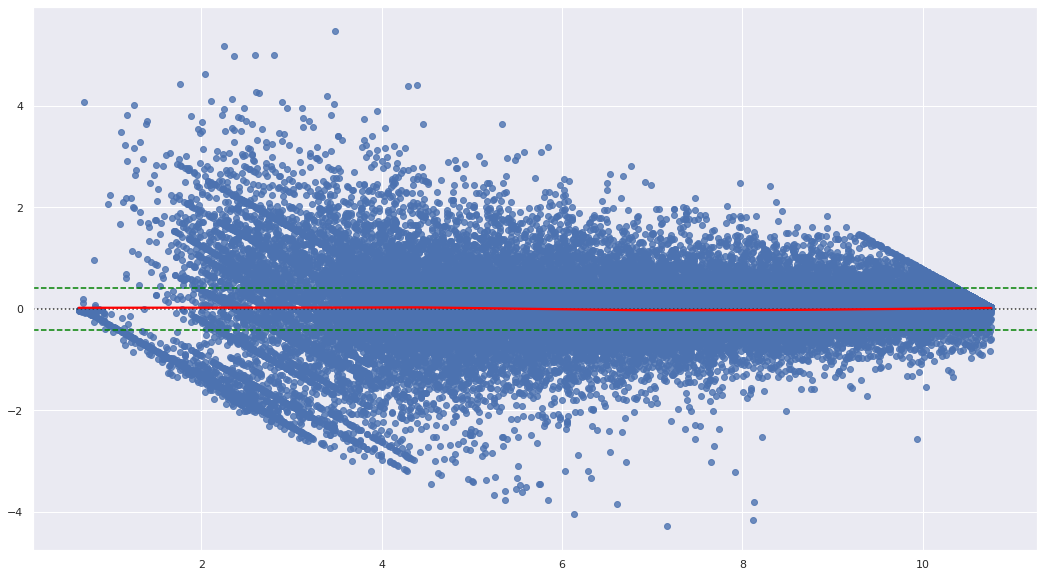

In [0]:
error = [m - n for m,n in zip(y_test, predict)]

plt.figure(figsize=(18,10))
sns.residplot(predict, error, lowess=True, line_kws={'color': 'red'})
plt.axhline(0.4148118122611779, color='green', linestyle='--')
plt.axhline(-0.4148118122611779, color='green', linestyle='--')
plt.show()

The purpose of this project was to create a model to predict the amount of money pledged to a crowdfunding campaign.  After analyzing the data, handling outliers, and experimenting with different modeling techniques, features were selected and a model was implemented.

The final model chosen was a Random Forest Regressor model that, after tuning and training, is able to predict pledge amounts for a campaign with an average +/- 1211.50 bias.  

During feature selection, 'usd_goal' and 'backers_count' were noted as having high feature importance.  Additionally, in some circumstances, pledge amounts exceeded the goal by 3:1 ratios or greater.  These amounts were limited during cleaning, however, the supporting high importance feature data may be contributing to the overall error.

<strong>Next Steps</strong>

Several elements are present in the data that may be useful to the predictability of the data.  While outside the scope of this current project, they may be worth exploring.

* Blurb data -  While some data is included in the model, other elements of the blurb data could provide useful insights
 * Does the wording of the blurb establish an appealing sentiment that could enhance predictability?
 * Does the blurb effectively communicate the campaign in the context of its category?
* Nested data -  Within the nested data were links to profile pictures and campaign related pictures that could potentially provide insight.
 * Does the profile picture convey appealing sentiment?
 * Do the dominant colors convey an overall mood (that may motivate contributors)?

While not all inclusive, these examples provide potentially interesting avenues to further explore.